## Summary of exploratory data analysis

The bullets that matter:
    

## Approach
* L1 logistic regression
    * Reason is so that cofficients are understable and intuitive to non-technical audience
    * L1 to reduce features due to correlations identified in EDA
* GridSearch on C value
    * Use AUC metric, as a metric for the quality of the resulting signal of **predicted probabilities** to apply for a credit card
    *  we will use AUC to evaluate the quality of our models with `gridsearchcv` as signal to identify converters
    * Plot ROC to visualize
* Experiment/Feature Engineering
    * Based on above, remove the features identified by L1 LogReg before trying to add new features to experiment
    * Funnel Halo Effect
    * Categorical for Time Diff
    * % Viewable Impressions
    * Frequency buckets?
* Business Performance Metrics
    * Baseline will be provided for the campaign that ran in Q4 (see details more below)
    * Model can be compared to this by using or model signal to 


## Define Business Performance Metrics

While we will use AUC to evaluate the quality of our models with `gridsearchcv`, we also want to caclulate performance business performance metrics of **ROI** and **Net Value**, as defined below.  Our focus will be to increase **Net Value** from an ad campaign, but we will also calculate ROI for reference.

To calculate these metrics, we need define how we will interpret the confusion matrix:

|True Class: Positive|True Class: Negative
------------------------------|:-------------:|:-------------:
**Predicted Class: Positive** |True Positives |False Positives
**Predicted Class: Negative** |False Negatives|True Negatives

Since we plan to use our model to predict how we should design our ad campaigns, we can interpret the predicted class to help us identify whether or not we'd like to reach users in a similar way:
* Positive: Signal to spend on user because of high likelihood to convert
* Negative: Signal to **not** spend on user
For example, if we predict a positive class for an observation in our dataset that was reached by 10 video ads and 15 display ads, we would plan on spend on similar users like this.

Based on this interpretation, we can develope a cost-benefit methodology based on the confusion matrix:

|True Class: Positive|True Class: Negative
-----------------------------|:------------------------------------------:|:-------------:
**Predicted Class Positive** |Application Value<br>- Cost of Reaching User|-Cost of Reaching User
**Predicted Class Negative** |0|0
**Assumptions**
* **ApplicationValue** = \$500 (The average value of a credit card application)
* **ReachCost** = \$0.033827 (The average cost of reaching a single user for our campaign)


Using this interpretation allows us define the following **ROI** and **Net Value** functions:

\begin{equation*}
ROI = \frac{Total Value}{Total Cost} - 1
\end{equation*}

\begin{equation*}
Net Value = Total Value - Total Cost
\end{equation*}

\begin{equation*}
Total Value = ApplicationValue * TP
\end{equation*}

\begin{equation*}
Total Cost = ReachCost * (TP + FP)
\end{equation*}

Once we have determined our best estimator with AUC and `gridsearchsv`, we can then tune our **threshold** for a postive signal based on the predicted probability from our logistic regression model.  We will tune the **threshold** to maximize **Net Value**.

## Important Data and Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
data = pd.read_csv('../data/DATA_FOR_MODEL_20perc.csv', sep=',')
#data = pd.read_csv('../data/DATA_FOR_MODEL_FULL.csv', sep=',')
data.head(10)

,User_ID,Impressions,TimeDiff_Minutes,TimeDiff_Minutes_AVG,Funnel_Upper_Imp,Funnel_Middle_Imp,Funnel_Lower_Imp,Campaign_Message_Travel_Imp,Campaign_Message_Service_Imp,Campaign_Message_Family_Travel_Imp,...,Creative_Size_320x480_Imp,Creative_Size_Uknown_Imp,Device_Desktop_Imp,Device_Other_Imp,Device_Mobile_Imp,Active_View_Eligible_Impressions,Active_View_Measurable_Impressions,Active_View_Viewable_Impressions,Clicks,Conversions
0,AMsySZYlP3l94iys9P9WaBXIWE6B,3,2.0,1.000000,0,3,0,0,3,0,...,0,0,0,0,3,0,0,0,NaN,NaN
1,AMsySZbdCy7kK0BqCq38AvgzDJ7y,3,1.0,0.500000,0,3,0,3,0,0,...,0,0,3,0,0,3,3,1,NaN,NaN
2,AMsySZbsx0jjk_iOfpRCVx2ss3v8,2,12.0,12.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
3,AMsySZZnAR-zSA0aCGVZkfhupUhU,5,23033.0,5758.250000,0,5,0,0,0,0,...,0,0,0,0,5,5,5,5,NaN,NaN
4,AMsySZb1yHw6ewPTnb7h39vBdCh8,2,188.0,188.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
5,AMsySZbMUcclS_w01crSZ23CgZsa,1,NaN,NaN,0,1,0,0,0,0,...,0,0,0,0,1,1,1,0,NaN,NaN
6,AMsySZbN3U0Y-dpMwJBHb5KWpB6S,444,73303.0,165.469526,0,85,359,283,161,0,...,0,85,444,0,0,359,359,314,NaN,NaN
7,AMsySZZYbLJhgekE6XQ52ea1bpKb,2,80.0,80.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
8,AMsySZaWJ0IyUoZmTqnYg4_LsylU,1,NaN,NaN,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,NaN,NaN
9,AMsySZbQxjkNdQtKIjG1m3fso1u_,9,56231.0,7028.875000,0,9,0,0,0,0,...,0,0,0,0,9,7,7,3,NaN,NaN


## Handle Missing Data

In [3]:
# For Clicks,Conversion, convert NULL values to zero
data['Clicks'].fillna(value=0,inplace=True)
data['Conversions'].fillna(value=0,inplace=True)

# Create a new categorical variable Converted, which will be 1 if the the user converted at least once, 
# and 0 if the user did not convert.
data['Converted'] = pd.Categorical([1 if x>0 else 0 for x in data['Conversions']])

# For TimeDiff_Minutes and TimeDiff_AVG, it is NULL when we only have 1 impression
# For now, replace with the median value and then add columns flagging the rows where we did this
# We will explore other options for handling this data in the feature engineering section
data['TimeDiff_NULL_FLAG'] = pd.Categorical(data['TimeDiff_Minutes'].isnull())

data['TimeDiff_Minutes'].fillna(value=data['TimeDiff_Minutes'].median(),inplace=True)
data['TimeDiff_Minutes_AVG'].fillna(value=data['TimeDiff_Minutes_AVG'].median(),inplace=True)

In [4]:
# confirm not nulls left dataset
data.isnull().sum()

User_ID                                 0
Impressions                             0
TimeDiff_Minutes                        0
TimeDiff_Minutes_AVG                    0
Funnel_Upper_Imp                        0
Funnel_Middle_Imp                       0
Funnel_Lower_Imp                        0
Campaign_Message_Travel_Imp             0
Campaign_Message_Service_Imp            0
Campaign_Message_Family_Travel_Imp      0
Campaign_Card_Cash_Rewards_Imp          0
Campaign_Card_Premium_Rewards_Imp       0
Campaign_Card_Other_Imp                 0
Creative_Type_Display_Imp               0
Creative_Type_TrueView_Imp              0
Creative_Type_RichMediaExpanding_Imp    0
Creative_Type_RichMedia_Imp             0
Creative_Size_728x90_Imp                0
Creative_Size_300x600_Imp               0
Creative_Size_300x250_Imp               0
Creative_Size_160x600_Imp               0
Creative_Size_468x60_Imp                0
Creative_Size_300x50_Imp                0
Creative_Size_320x50_Imp          

In [5]:
#Show the distribution of impressions (should affect all other rows features based on exploratory analysis)
data['Impressions'].describe()

count    3.036639e+06
mean     4.895185e+00
std      1.600795e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.600000e+03
Name: Impressions, dtype: float64

In [6]:
#Remove outliers (users with more than ~50 impressions, 3 standard devs above the mean of 4.9 impressions)
print max(data['Impressions'])
data = data[data['Impressions']<=50]
print max(data['Impressions'])

5600
50


In [7]:
X=data.drop(['User_ID','Conversions','Converted'],axis=1)
y=data['Converted']

In [8]:
# Split into Train/Test 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

## Business Performance Functions and Baseline Benchmark

In [9]:
# Define ROI function
# *See section "Define Business Performance Metrics" for more details
def ROI(y,y_pred,app_value,avg_user_cost):
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=y_pred).ravel()
    
    total_value=float(tp*app_value)
    total_cost=float((tp+fp)*avg_user_cost)
    ROI=total_value/total_cost-1
    
    return ROI

In [10]:
# Define New Value function
# *See section "Define Business Performance Metrics" for more details
def Net_Value(y,y_pred,app_value,avg_user_cost):
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=y_pred).ravel()
    
    total_value=float(tp*app_value)
    total_cost=float((tp+fp)*avg_user_cost)
    Net_Value=total_value-total_cost
    
    return Net_Value

#### Basline Performance
Get baseline performance by assuming our classified producted "1" (or "positive") for all of our dataset observations.
**NOTE:** Baseline benchmark should be calculated on test dataset.

In [11]:
# Assumptions:
#    Value of credit card application=$500
#    Avg cost of reaching a user=$0.033827
ROI_benchmark = ROI(y=y_test,
                    y_pred=np.ones(y_test.size),
                    app_value=500,
                    avg_user_cost=0.033827)
Net_Value_benchmark = Net_Value(y=y_test,
                                y_pred=np.ones(y_test.size),
                                app_value=500,
                                avg_user_cost=0.033827)

In [25]:
print "Baseline Net Value: {0:.0f}".format(Net_Value_benchmark)
print "Baseline ROI: {0:.1f}%".format(ROI_benchmark*100)

Baseline Net Value: 15690
Baseline ROI: 77.3%


## L1 Logistic Regression - All Existing Features

Use L1 regularization with Logistic Regression to Identify Important/Non-Important variables

In [26]:
# Standardization: bring all of our features onto the same scale
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [27]:
# Cross-validation: 5 cross validation iterations with 30% test / 70% train
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

In [28]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.001,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 20min 28s, sys: 48.9 s, total: 21min 17s
Wall time: 20min 38s


In [29]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.731116033592


**Notes**
* **AUC of 0.73** is "Fair" quality model
* Good start, but we will see if can improve this score with some new features
* Before that, we will:
    * Review the current model coefficients
    * Plot distribution of predicted probabilities
    * Plot the ROC against the Test data for reference

#### Show Coefficients

In [30]:
best_logreg = clf.best_estimator_

In [95]:
# Look at coefficients that are zero
#lgl1_coeff = pd.DataFrame(zip(X.columns,logreg.coef_),columns=['Features','Coefficients'])
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':best_logreg.coef_[0]})

In [97]:
# Show non-important / zero'd features
best_coeff[best_coeff['Coefficients']==0]

,Coefficients,Features
0,0.0,Impressions
2,0.0,TimeDiff_Minutes_AVG
3,0.0,Funnel_Upper_Imp
6,0.0,Campaign_Message_Travel_Imp
7,0.0,Campaign_Message_Service_Imp
12,0.0,Creative_Type_Display_Imp
13,0.0,Creative_Type_TrueView_Imp
14,0.0,Creative_Type_RichMediaExpanding_Imp
15,0.0,Creative_Type_RichMedia_Imp
16,0.0,Creative_Size_728x90_Imp


In [115]:
#Show important features
kept_coeff=best_coeff[best_coeff['Coefficients']!=0]
kept_coeff

,Coefficients,Features
1,0.064719,TimeDiff_Minutes
4,-0.396835,Funnel_Middle_Imp
5,0.054916,Funnel_Lower_Imp
8,0.085190,Campaign_Message_Family_Travel_Imp
9,0.006753,Campaign_Card_Cash_Rewards_Imp
10,-0.049592,Campaign_Card_Premium_Rewards_Imp
11,0.021681,Campaign_Card_Other_Imp
22,-0.042019,Creative_Size_320x50_Imp
23,0.006210,Creative_Size_320x420_Imp
27,0.129406,Device_Desktop_Imp


In [116]:
# Calculate Odds Ratios 
# For intuitive understanding of coefficients
kept_coeff.loc[:,'Odds_Ratios']=kept_coeff['Coefficients'].apply(np.exp)
kept_coeff

,Coefficients,Features,Odds_Ratios
1,0.064719,TimeDiff_Minutes,1.066859
4,-0.396835,Funnel_Middle_Imp,0.672445
5,0.054916,Funnel_Lower_Imp,1.056452
8,0.085190,Campaign_Message_Family_Travel_Imp,1.088924
9,0.006753,Campaign_Card_Cash_Rewards_Imp,1.006775
10,-0.049592,Campaign_Card_Premium_Rewards_Imp,0.951617
11,0.021681,Campaign_Card_Other_Imp,1.021918
22,-0.042019,Creative_Size_320x50_Imp,0.958852
23,0.006210,Creative_Size_320x420_Imp,1.006230
27,0.129406,Device_Desktop_Imp,1.138153


**Interpretation**
For every standard deviation increase of 1 in the feature, there is the following increase in the odds for applying for a credit card:

Feature|Odds Improvment w/<br>Std Dev Increase of 1
-------|:-----:
TimeDiff_Minutes|6.69%
Funnel_Middle_Imp|-32.76%
Funnel_Lower_Imp|5.65%
Campaign_Message_Family_Travel_Imp|8.89%
Campaign_Card_Cash_Rewards_Imp|0.68%
Campaign_Card_Premium_Rewards_Imp|-4.84%
Campaign_Card_Other_Imp|2.19%
Creative_Size_320x50_Imp|-4.11%
Creative_Size_320x420_Imp|0.62%
Device_Desktop_Imp|13.82%
Device_Other_Imp|-7.60%
Device_Mobile_Imp|-9.04%
Clicks|1.12%
TimeDiff_NULL_FLAG|-13.71%

**Domain-Knowledge Notes**
* It's interesting how much negative impact impressios to middle funnel has.  The potential explanation for this is that users that are being reached with middle-funnel campaigns are already less likely to be convert (compared to users who are already engaged with the client's brand and being reached with lower funnel campaigns).  It is still valuable to include this feature as it captures the difficulty converting users higher up in the marketing funnel.
* An longer time between first and last impressions has a positive impact, possibly because being reminded about the credit card over a longer time-period allows the user to evaluate the need for the credit card.  It also makes sense that there's a penalty for when users only have 1 impression (TimeDiff_NULL_FLAG)
* The Family Travel Message influence the most positively, we should review the ad creative and message for possible best practices.
* Desktop impressions have the greatest positive influence.  One potential limiation/cause is because our users are in fact "unique cookies", so if a user saw ads on a mobile device, but switched to their desktop to apply for the credit, then we would not be able to see that in our data.  This may be causing a bias in our dataset that we should be aware of.
* It's interesting how small the influence is from Clicks

#### Plot distribution of Predicted Probabilities

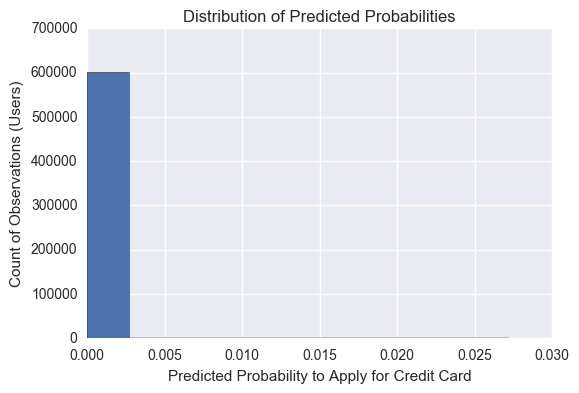

In [118]:
#Distribution of predictions
plt.hist(scores);
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability to Apply for Credit Card")
plt.ylabel("Count of Observations (Users)");

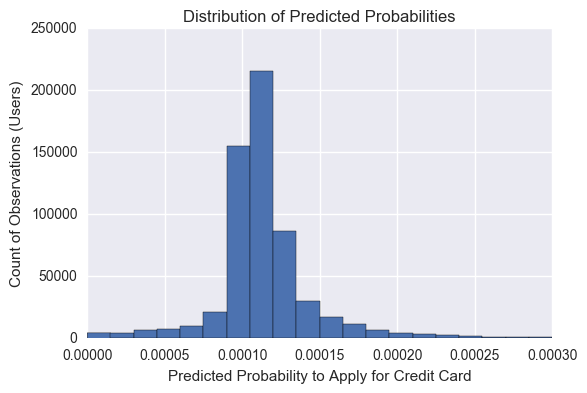

In [119]:
#Distribution of predictions (Zoom in at probabilites<0.03%)
max_in_chart=0.0003
plt.hist(scores[scores<max_in_chart],bins=20);
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability to Apply for Credit Card")
plt.ylabel("Count of Observations (Users)");

**Notes**
* The large peak in the middle is an indication of how how hard it is to distinquish our observations from each other
* However, there is a long tail to the right as seen in the first graph

#### Plot ROC/AUC w/ Test Dataset (Reference Point)

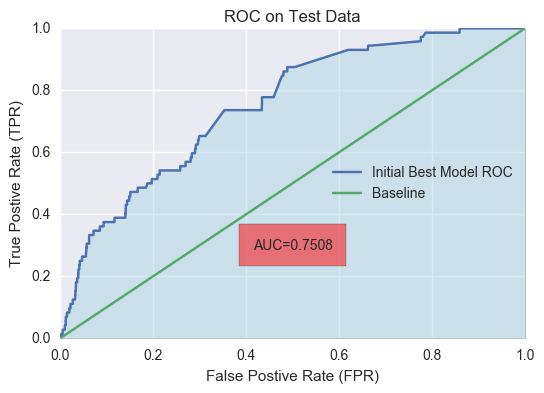

In [120]:
#Plot ROC
scores = best_logreg.predict_proba(X_test_std)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)
plt.plot(fpr,tpr,label='Initial Best Model ROC')

#Plot reference line
z=np.linspace(0,1,20)
plt.plot(z,z,label='Baseline');

#Calculate AUC
area=auc(fpr, tpr)
plt.text(0.5, 0.3, 'AUC={0:0.4f}'.format(area), style='normal',
         verticalalignment='center', horizontalalignment='center',
         bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

# AUC shading
x = np.linspace(0.0, 1, 11)
plt.fill_between(fpr, 0, tpr, where=tpr >= 0, facecolor='lightblue', interpolate=True,alpha=0.5)

#Plot details
plt.title("ROC on Test Data")
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Postive Rate (TPR)")
plt.legend(loc='right');

## Business Metrics on Final Model

In [ ]:
roc_df = pd.DataFrame({'thresholds':thresholds,
                  'tpr':tpr,
                  'fpr':fpr}, columns=['thresholds','tpr','fpr'])
roc_df.head()

In [ ]:
#Get Threshold at various tpr and fpr
breakouts=100
roc_cuts=None
roc_cuts=pd.DataFrame()
for i in range(0,breakouts):
    threshold_cut = i/float(breakouts)+0.1
    temp=roc_df[roc_df['tpr']<=threshold_cut].sort_values(by='thresholds',ascending=True).head(1)
    roc_cuts=pd.concat([roc_cuts,temp])
roc_cuts

In [ ]:
#ROI benchmark
# Get baseline value of campaign AS IS
# Baseline scenario is we go after ALL the users in the dataset
# Value of credit card application=$500
# Avg cost of reaching user=$0.033827
ROI(y=y_test,
    y_pred=np.ones(y_test.size),  #predicting all will convert (or worthwhile going after)
    app_value=500,
    avg_user_cost=0.033827)

In [ ]:
%%time
#breakouts=10
#ROI_results=pd.DataFrame()
#for i in range(0,breakouts):
#    threshold_cut = i/10.+0.1
#    roc_cuts=pd.concat([roc_cuts,temp])
#roc_cuts

ROIs=[]
Net_Values=[]

for i in range(0,breakouts):
    prob_threshold=roc_cuts.iloc[i,0]
    scores = best_logreg.predict_proba(X_test_std)[:,1]
    y_pred = [1 if x>=prob_threshold else 0 for x in scores]
    
    ROIs.append(ROI(y=y_test,y_pred=y_pred,app_value=500,avg_user_cost=0.033827))
    Net_Values.append(Net_Value(y=y_test,y_pred=y_pred,app_value=500,avg_user_cost=0.033827))

In [ ]:
value_df=pd.DataFrame({'Thresholds':roc_cuts['thresholds'],
                       'tpr':roc_cuts['tpr'],
                       'fpr':roc_cuts['fpr'],
                       'ROI':ROIs,
                       'Net_Value':Net_Values})


value_df

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(value_df['Thresholds'],value_df['ROI'])


#ax1.plot(t, s1, 'b-')
#ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
#ax1.set_ylabel('exp', color='b')
#ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(value_df['Thresholds'],value_df['Net_Value'])

#s2 = np.sin(2 * np.pi * t)
#ax2.plot(t, s2, 'r.')
#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')

fig.tight_layout()

In [ ]:
plt.plot(value_df['tpr'],value_df['Net_Value']);

In [ ]:
plt.plot(value_df['tpr'],value_df['ROI']);

In [ ]:
#Print the distribution of scares by actual 1 or 0 on test data? (like in ROC yt video)

In [ ]:
#np.exp(-0.167144)